In [ ]:
## REPLACE WITH PATH TO INVOICE.CSV AND CLIENT.CSV BEFORE RUNNING
client_csv_path = "Data/client.csv"
invoice_csv_path = "Data/invoice.csv"
## REPLACE WITH PATH TO INVOICE.CSV AND CLIENT.CSV BEFORE RUNNING

In [29]:
## Import packages
import json
import optuna
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from typing import Literal, Callable
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

# To remove warnings
warnings.filterwarnings("ignore")

In [ ]:
## Data Importing functions

def import_client(filepath : str = client_csv_path) -> pd.DataFrame:
    """
    Function to import client dataset.
    """
    return pd.read_csv(filepath)

def import_invoice(filepath : str = invoice_csv_path) -> pd.DataFrame:
    """
    Function to import invoice dataset.
    """
    return pd.read_csv(filepath)

In [31]:
## Data Preprocessing functions

def convert_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts date column to an integer representing 
    the number of days since the earliest date.
    *Column name 'date' is fixed for both datasets.
    """

    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'], dayfirst = True)
    
    # Find the earliest date
    earliest_date = df['date'].min()
    
    # Calculate the number of days since the earliest date
    df['date'] = (df['date'] - earliest_date).dt.days
    
    return df

def drop_duplicates(df : pd.DataFrame, logs : bool = False) -> pd.DataFrame:
    """
    Prints the result of a duplicate check.
    Drops duplicates if they exist.
    """
    if df.duplicated().any(): # Duplicates check
        if logs:
            print("Duplicates found! Cleaning them up...")
        df = df.drop_duplicates() # Drops duplicates
        df = df.reset_index(drop = True) # Resets indexes
    elif logs:
        print("No duplicates found!")
    return df

def convert_to_categorical(
        df : pd.DataFrame,
        cols : list[str]
        ) -> pd.DataFrame:
    """
    Converts list of column names to categorical datatype.
    """
    df[cols] = df[cols].astype('category')
    return df

def one_hot_encode_categorical(df):
    """
    This function takes a DataFrame, identifies categorical columns,
    and applies one-hot encoding to those columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with categorical columns one-hot encoded.
    """
    # Check for categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Apply one-hot encoding to categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    return df_encoded

In [32]:
## Data Feature Engineering functions

def aggregate_invoice(
        df : pd.DataFrame, 
        categorical_cols : list[str]
    ) -> pd.DataFrame:
    """
    Aggregate the invoice dataframe by id and generate features.
    Calculates sum, mean, max, and std for each consommation_level and date
    and counts number of invoices under each id.
    """

    # Calculate sum, mean, max, and std for 
    # each consm_level and date. 
    # Also count number of invoices for each id.
    agg_dict = {
        'counter_coefficient' : ['sum', 'mean', 'max', 'std'],
        'consommation_level_1' : ['sum', 'mean', 'max', 'std'],
        'consommation_level_2' : ['sum', 'mean', 'max', 'std'],
        'consommation_level_3' : ['sum', 'mean', 'max', 'std'],
        'consommation_level_4' : ['sum', 'mean', 'max', 'std'],
        'date' : ['sum', 'mean', 'max', 'std'],
        'id' : 'count', 
    }

    for col in df.columns:
        if any(col.startswith(prefix) for prefix in categorical_cols):
            agg_dict[col] = 'mean'

    df = df.groupby('id').agg(agg_dict).reset_index()
    df.columns = ['_'.join(col) if col[1] != '' else col[0] for col in df.columns]
    df = df.rename(columns = {'id_count' : 'invoice_count'})
    return df

def manual_fix_names(
        df : pd.DataFrame,
        new_col_names : list[str]
        ) -> pd.DataFrame:
    """
    Manually sets the column names of a dataframe.
    """
    df.columns = new_col_names
    return df


In [33]:
## Data Joining functions

def merge(
        client_df : pd.DataFrame,
        invoice_df : pd.DataFrame,
        merge_by : str = "id"
        ) -> pd.DataFrame:
    """
    Merges two dataframes.
    Merges on 'id' column by default (for client and invoice).
    """
    merged_df = client_df.merge(
        invoice_df, on = merge_by, how = 'left')
    return merged_df


In [34]:
## Dimensionality Reduction functions

def prep_dataframe(
        df : pd.DataFrame, 
        response_col_name : str,
        cat_col_names : list[str] = [],
        scale : bool = True,
        OHE : bool = True,
        drop_id : bool = True
        ) -> pd.DataFrame:
    """
    For scaling and one-hot encoding dataframe.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        response_col_name (str): Name of response column
        cat_col_names (list[str]): List of categorical column names to evaluate.
        scale (bool): Indicate if data should be scaled
        OHE (bool): Indicate if categorical variables should undergo One-Hot Encoding

    Returns:
        pd.DataFrame: A DataFrame with columns scaled/One-Hot Encoded
    """

    if drop_id:
        df = df.drop(columns = ['id']) 
        # Drop id column as it is not useful for predicting

    if 'id' in cat_col_names:
        cat_col_names.remove('id') 
        # Remove 'id' as it no longer exists in dataframe

    if response_col_name in cat_col_names:
        cat_col_names.remove(response_col_name)
    # Exclude doing OHE on response column

    # Identify numerical columns 
    # by excluding categorical and response columns
    num_col_names = [
        col for col in df.columns 
        if col not in cat_col_names 
        and col != response_col_name
    ]

    y = df[response_col_name].values # Response column
    X_num = df[num_col_names].values # Numerical columns
    X_cat = df[cat_col_names].values # Categorical columns

    if scale:
        # Scale numerical features
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_num)

    if OHE:
        # One-hot encode categorical features
        encoder = OneHotEncoder(sparse_output = False, drop = 'first')  
        # drop = 'first' to avoid dummy variable trap
        X_cat = encoder.fit_transform(X_cat)
    
    # Combine the scaled numerical and encoded categorical features
    X_prep = pd.DataFrame(
        data = np.hstack((X_num, X_cat)),  # Horizontal stack to combine arrays
        columns = num_col_names + list(encoder.get_feature_names_out(cat_col_names))
    )

    # Create a new DataFrame including the response variable
    prep_df = pd.DataFrame(X_prep, columns = X_prep.columns)
    prep_df[response_col_name] = y

    return prep_df

def principal_component_analysis(
        df : pd.DataFrame, 
        response_col_name : str,
        cat_col_names : list[str] = [], 
        var : float = 0.95, 
        logs : bool = False
        ) -> pd.DataFrame:
    """
    For reducing the dimensions of a dataframe using PCA.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        response_col_name (str): Name of response column
        cat_col_names (list[str]): List of categorical column names to evaluate.
        var (float): Proportion of variance that should be preserved
        logs (bool): Indicate if logs should be printed

    Returns:
        pd.DataFrame: A DataFrame that has undergone PCA
    """

    if response_col_name in cat_col_names:
        cat_col_names.remove(response_col_name)
    # Exclude doing OHE on response column

    # Identify numerical columns 
    # by excluding categorical and response columns
    num_col_names = [
        col for col in df.columns 
        if col not in cat_col_names 
        and col != response_col_name
    ]

    y = df[response_col_name].values # Response column
    X_num = df[num_col_names].values # Numerical columns
    X_cat = df[cat_col_names].values # Categorical columns

    pca = PCA(n_components = var) 
    # Keep 'var' proportion of the variance : default 95%
    X_pca = pca.fit_transform(X_num) 

    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns = pca_columns)

    df_modified = pd.concat(
        [
            df_pca, 
            pd.DataFrame(X_cat, columns = cat_col_names), 
            pd.Series(y, name = response_col_name)
        ], 
        axis = 1)
    
    if logs:
        print(f"Number of components selected: {pca.n_components_}")
        print("Explained variance ratio for each component:", pca.explained_variance_ratio_)
        print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())
        print("Final DataFrame with PCA applied to numeric columns:")
        print(df_modified.head())

    return df_modified

def filter_low_variance(
        df : pd.DataFrame, 
        response_col_name : str,
        threshold: float = 0.1
        ) -> pd.DataFrame:
    """
    Filter numeric columns based on a variance threshold.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        response_col_name (str): Name of response column
        threshold (float): The variance threshold for filtering columns.

    Returns:
        pd.DataFrame: A DataFrame with low variance numeric columns removed.
    """
    
    # Identify numerical columns 
    # by excluding response column
    num_col_names = [
        col for col in df.columns 
        if col != response_col_name
    ]

    # Calculate the variance for each numeric column
    variances = df[num_col_names].var()

    # Keep response column
    high_variance_cols = [response_col_name]

    # Filter columns with variance greater than the threshold : default 0.1
    cols_to_keep = variances[variances > threshold].index.tolist()
    high_variance_cols.extend(cols_to_keep)

    # Create a new DataFrame with only the selected columns
    filtered_df = df[high_variance_cols]

    return filtered_df


In [35]:
## Data Visualisation functions

def heatmap(
        df : pd.DataFrame,
        excluded_cols : list[str] = []
        ) -> None:
    """
    Plots a Correlation Heatmap.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        excluded_cols (list[str]): Columns to be excluded from the heatmap.
        annotate (float): To annotate the heatmap with correlation values.
    """
    
    # Identify desired columns 
    # by excluding undesired column
    if excluded_cols:
        col_names = [
            col for col in df.columns 
            if col not in excluded_cols
        ]
        X = df[col_names]
    else:
        X = df

    corr_matrix = X.corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(corr_matrix, cmap='coolwarm')
    fig.colorbar(cax)
    plt.xticks(ticks = np.arange(len(corr_matrix.columns)), labels = corr_matrix.columns, rotation = 90)
    plt.yticks(ticks = np.arange(len(corr_matrix.columns)), labels = corr_matrix.columns)
    plt.show()


In [36]:
## Data Balancing functions

def undersample_data(
        df: pd.DataFrame, 
        response_col_name: str, 
        proportion: float = 1
        ) -> pd.DataFrame:
    """
    Perform undersampling to balance the classes in the dataset based on a specified proportion.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        response_col_name (str): The name of the target column (class label).
        proportion (float): The desired ratio of minority to majority class samples (e.g., 0.5 for 1:2).

    Returns:
        pd.DataFrame: A balanced DataFrame with samples from both classes according to the specified proportion.
    """

    # Separate the majority and minority classes
    majority_class = df[response_col_name].value_counts().idxmax()
    minority_class = df[response_col_name].value_counts().idxmin()

    # Split the DataFrame into majority and minority
    df_majority = df[df[response_col_name] == majority_class]
    df_minority = df[df[response_col_name] == minority_class]

    # Calculate the number of samples to take from the majority class
    n_minority = len(df_minority)
    n_majority = int(n_minority / proportion)

    # Ensure we do not sample more than available
    n_majority = min(n_majority, len(df_majority))

    # Randomly sample from the majority class
    df_majority_sampled = df_majority.sample(n = n_majority, random_state = 42)

    # Combine the minority class with the undersampled majority class
    df_balanced = pd.concat([df_majority_sampled, df_minority])

    # Shuffle the resulting DataFrame
    df_balanced = df_balanced.sample(frac = 1, random_state = 42).reset_index(drop = True)

    return df_balanced

def smote(df : pd.DataFrame, response_col_name : str) -> pd.DataFrame:
    """
    Apply SMOTE to oversample the minority class in the dataset and return a balanced DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        response_col_name (str): The name of the target column (class label).
        
    Returns:
        pd.DataFrame: A DataFrame with balanced data using SMOTE.
    """
    y = df[response_col_name]
    X = df.drop(columns=[response_col_name])
    
    sm = SMOTE(random_state = 42)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    
    df_resampled = pd.concat(
        [
            pd.DataFrame(X_resampled, columns = X.columns), 
            pd.DataFrame(y_resampled, columns = [response_col_name])
        ], 
        axis = 1)
    
    return df_resampled

def balance_data(
        df : pd.DataFrame, 
        response_col_name : str,
        prop_synthetic_data : float = 0.25
        ) -> pd.DataFrame:
    """
    Apply SMOTE and undersampling to return a balanced DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        response_col_name (str): The name of the target column (class label).
        prop_synthetic_data (float): Proportion of final data that will be synthetic. (0 to 0.5)

    Returns:
        pd.DataFrame: A DataFrame with balanced data.
    """

    if prop_synthetic_data < 0:
        prop_synthetic_data = 0
    elif prop_synthetic_data >= 0.5:
        prop_synthetic_data = 0.499

    df = undersample_data(
        df = df, 
        response_col_name = response_col_name,
        proportion = (1 - 2 * prop_synthetic_data))
    
    df = smote(df, response_col_name = response_col_name)

    return df

In [37]:
## Feature Importance function

def get_feature_importance(
        df : pd.DataFrame, 
        response_col_name : str,
        excluded_cols : list[str] = []
        ) -> None:
    """
    Uses Random Forests to identify the most important features in predicting response.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        response_col_name (str): The name of the target column (class label).
        excluded_cols (list[str]): Columns to be excluded from the heatmap.
        scale (bool): To scale the dataset or not.
    """

    col_names = [
        col for col in df.columns 
        if col not in excluded_cols 
        and col != response_col_name
    ]

    X = df[col_names]
    y = df[response_col_name]

    X_train, _, y_train, _ = train_test_split(
        X, y, test_size = 0.3, random_state = 42, stratify = y)
    
    # Initialised the Random Forest Classifier with class weight to handle class imbalance
    rf_model = RandomForestClassifier(class_weight = 'balanced', random_state = 42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Feature importance
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame for feature importance
    features = X.columns  # Get feature names
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

    # Sort features by importance
    importance_df = importance_df.sort_values(by = 'Importance', ascending = False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='b')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in Random Forest')
    plt.show()


In [38]:
## Define Data Processing workflow

def data_processing(logs : bool = False) -> pd.DataFrame: 
    client_df = import_client()
    invoice_df = import_invoice()
    client_df = convert_date(client_df) # Convert date cols
    invoice_df = convert_date(invoice_df)
    # Drop duplicates rows
    client_df = drop_duplicates(client_df, logs = logs) 
    invoice_df = drop_duplicates(invoice_df, logs = logs)
    cli_categorical_column_names = [
        'region', 'dis', 'id', 'catg', 'target'
    ]
    inv_categorical_column_names = [
        'tarif_type', 'counter_statue', 'reading_remarque', 'counter_type'
    ]
    client_df = convert_to_categorical( # Convert categorical cols
        client_df, cols = cli_categorical_column_names
        )
    invoice_df = convert_to_categorical(
        invoice_df, cols = inv_categorical_column_names
    )
    invoice_df = prep_dataframe(
        invoice_df,
        'id',
        inv_categorical_column_names,
        scale = False,
        drop_id = False
    )
    invoice_df = aggregate_invoice(
        invoice_df,
        inv_categorical_column_names) # Aggregate invoices
    invoice_df = manual_fix_names( # Fix column names manually
        invoice_df, 
        new_col_names = [
            'id', 
            'count_coef_sum', 'count_coef_mean',
            'count_coef_max', 'count_coef_std',
            'cons_level_1_sum', 'cons_level_1_mean', 
            'cons_level_1_max', 'cons_level_1_std',
            'cons_level_2_sum', 'cons_level_2_mean', 
            'cons_level_2_max', 'cons_level_2_std',
            'cons_level_3_sum', 'cons_level_3_mean', 
            'cons_level_3_max', 'cons_level_3_std',
            'cons_level_4_sum', 'cons_level_4_mean', 
            'cons_level_4_max', 'cons_level_4_std',
            'date_sum', 'date_mean', 'date_max', 'date_std',
            'invoice_count', 
            'tarif_type_10_prop', 'tarif_type_11_prop',
            'tarif_type_12_prop', 'tarif_type_13_prop',
            'tarif_type_14_prop', 'tarif_type_15_prop', 
            'tarif_type_21_prop', 'tarif_type_29_prop', 
            'tarif_type_30_prop', 'tarif_type_40_prop',
            'tarif_type_45_prop',
            'counter_statue_1_prop', 'counter_statue_2_prop',
            'counter_statue_3_prop', 'counter_statue_4_prop', 
            'counter_statue_5_prop',
            'reading_remarque_7_prop', 'reading_remarque_8_prop',
            'reading_remarque_9_prop', 'counter_type_GAZ_prop'
            ]
        )
    df = merge(client_df = client_df, invoice_df = invoice_df) # Merge
    df = prep_dataframe( # Prep for PCA
        df = df,
        response_col_name = 'target',
        cat_col_names = cli_categorical_column_names
    )
    if logs:
        heatmap(df)
        # Get feature importance for pre-reduced data
        get_feature_importance(df, 'target', cli_categorical_column_names)
    df = principal_component_analysis( # Do PCA
        df = df,
        response_col_name = 'target'
    )
    # Do Low Variance Filter
    df = filter_low_variance(df, response_col_name = 'target')
    if logs:
        heatmap(df)
        # Get feature importance for post-reduced data
        get_feature_importance(df, 'target')
        # Print pre-balancing proportion of response
        print(df['target'].value_counts()) 
    df = balance_data( # Do balancing 
        df = df, 
        response_col_name = 'target', 
        prop_synthetic_data = 0.4 # Final proportion of synthetic data
        ) 
    if logs:
        # Print post-balancing proportion of response
        print(df['target'].value_counts()) 
        print(df.head())
    return df


In [39]:
## Define Models

def logistic_regression(
        train_data : pd.DataFrame,
        response_col : str,
        test_data : pd.DataFrame,
        prob : bool = False
    ) -> np.ndarray[np.int64 | np.float64]:
    """
    Uses logistic regression algorithm to do classification.

    Parameters:
        train_data (pd.DataFrame): The input DataFrame containing the train data.
        response_col (str): The name of the target column (class label).
        test_data (pd.DataFrame): The input DataFrame containing the test data.
        prob (bool): To return a vector of probabilities instead of class predictions.
        
    Returns:
        np.ndarray: An array with model predictions.
    """

    y = train_data[response_col]
    X = train_data.drop(columns = [response_col])

    Model = LogisticRegression(random_state = 42)
    Model.fit(X = X, y = y)

    feature_names = X.columns
    if prob:
        y_pred = Model.predict_proba(test_data[feature_names])[:, 1]
    else:
        y_pred = Model.predict(test_data[feature_names])

    return y_pred

def k_nearest_neighbors(
        train_data : pd.DataFrame,
        response_col : str,
        test_data : pd.DataFrame,
        prob : bool = False,
        k : int = 5,
        weights : Literal['uniform', 'distance'] = 'uniform',
        power_parameter : int = 2
    ) -> np.ndarray[np.int64 | np.float64]:
    """
    Uses k-nearest neighbors algorithm to perform classification.

    Parameters:
        train_data (pd.DataFrame): The input DataFrame containing the train data.
        response_col (str): The name of the target column (class label).
        test_data (pd.DataFrame): The input DataFrame containing the test data.
        prob (bool): To return a vector of probabilities instead of class predictions.
        k (int): Number of nearest neighbors to consider.
        weights ({'uniform', 'distance'}): Weight function used in prediction.
        power_parameter (int): Power parameter for the Minkowski metric. 
    
    Returns:
        np.ndarray: An array with model predictions.
    """
    
    y = train_data[response_col]
    X = train_data.drop(columns = [response_col])

    Model = KNeighborsClassifier(
        n_neighbors = k,
        weights = weights,
        p = power_parameter
    )
    Model.fit(X = X, y = y)

    feature_names = X.columns
    if prob:
        y_pred = Model.predict_proba(test_data[feature_names])[:, 1]
    else:
        y_pred = Model.predict(test_data[feature_names])

    return y_pred

def decision_tree(
        train_data : pd.DataFrame,
        response_col : str,
        test_data : pd.DataFrame,
        prob : bool = False,
        criterion : Literal['gini', 'entropy', 'log_loss'] = 'gini',
        splitter : Literal['best', 'random'] = 'best',
        max_depth : int = None,
        min_samples_split : float = None,
        min_samples_leaf : float = None
    ) -> np.ndarray[np.int64 | np.float64]:
    """
    Uses decision tree algorithm to perform classification.

    Parameters:
        train_data (pd.DataFrame): The input DataFrame containing the train data.
        response_col (str): The name of the target column (class label).
        test_data (pd.DataFrame): The input DataFrame containing the test data.
        prob (bool): To return a vector of probabilities instead of class predictions.
        criterion ({'gini', 'entropy', 'log_loss'}): The function to measure the quality of a split.
        splitter ({'best', 'random'}): The strategy used to choose the split at each node.
        max_depth (int): The maximum depth of the tree.
        min_samples_split (float 0 < x < 1): Fraction of total sample representing minimum number of samples required to split an internal node.
        min_samples_leaf (float 0 < x < 1): Fraction of total sample representing minimum number of samples for each node.

    Returns:
        np.ndarray: An array with model predictions.
    """
    
    if min_samples_split is None:
        min_samples_split = 2

    if min_samples_leaf is None:
        min_samples_leaf = 1

    y = train_data[response_col]
    X = train_data.drop(columns = [response_col])

    Model = DecisionTreeClassifier(
        criterion = criterion,
        splitter = splitter,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        random_state = 42
    )
    Model.fit(X = X, y = y)

    feature_names = X.columns
    if prob:
        y_pred = Model.predict_proba(test_data[feature_names])[:, 1]
    else:
        y_pred = Model.predict(test_data[feature_names])

    return y_pred

def random_forest(
        train_data : pd.DataFrame,
        response_col : str,
        test_data : pd.DataFrame,
        prob : bool = False,
        n_estimators : int = 100,
        criterion : Literal['gini', 'entropy', 'log_loss'] = 'gini',
        max_depth : int = None,
        min_samples_split : float = None,
        min_samples_leaf : float = None
    ) -> np.ndarray[np.int64 | np.float64]:
    """
    Uses random forest algorithm to perform classification.

    Parameters:
        train_data (pd.DataFrame): The input DataFrame containing the train data.
        response_col (str): The name of the target column (class label).
        test_data (pd.DataFrame): The input DataFrame containing the test data.
        prob (bool): To return a vector of probabilities instead of class predictions.
        n_estimators (int): The number of trees in the forest.
        criterion ({'gini', 'entropy', 'log_loss'}): The function to measure the quality of a split.
        max_depth (int): The maximum depth of the tree.
        min_samples_split (float 0 < x < 1): Fraction of total sample representing minimum number of samples required to split an internal node.
        min_samples_leaf (float 0 < x < 1): Fraction of total sample representing minimum number of samples for each node.

    Returns:
        np.ndarray: An array with model predictions.
    """

    if min_samples_split is None:
        min_samples_split = 2

    if min_samples_leaf is None:
        min_samples_leaf = 1

    y = train_data[response_col]
    X = train_data.drop(columns = [response_col])

    Model = RandomForestClassifier(
        n_estimators = n_estimators,
        criterion = criterion,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        random_state = 42
    )
    Model.fit(X = X, y = y)

    feature_names = X.columns
    if prob:
        y_pred = Model.predict_proba(test_data[feature_names])[:, 1]
    else:
        y_pred = Model.predict(test_data[feature_names])

    return y_pred

def light_gradient_boosting_machine(
        train_data : pd.DataFrame,
        response_col : str,
        test_data : pd.DataFrame,
        prob : bool = False,
        num_iterations : int = 100,
        learning_rate : float = 0.1,
        num_leaves : int = 31,
        max_depth : int = -1,
        bagging_freq : int = 0,
        bagging_fraction : float = 1,
        feature_fraction : float = 1,
        lambda_l1 : float = 0,
        lambda_l2 : float = 0,
        min_split_gain : float = 0
    ) -> np.ndarray[np.int64 | np.float64]:
    """
    Uses light gradient boosting machine algorithm to perform classification.

    Parameters:
        train_data (pd.DataFrame): The input DataFrame containing the train data.
        response_col (str): The name of the target column (class label).
        test_data (pd.DataFrame): The input DataFrame containing the test data.
        prob (bool): To return a vector of probabilities instead of class predictions.
        num_iterations (int): The number of boosting iterations.
        learning_rate (float > 0): Shrinkage rate.
        num_leaves (int 1 < x <= 131072): The max number of leaves in one tree.
        max_depth (int): Limit the max depth for tree model. <= 0 means no limit.
        bagging_freq (int >= 0): Frequency for bagging.
        bagging_fraction (float 0 < x <= 1): To randomly selecting data without resampling.
        feature_fraction (float 0 < x <= 1): To randomly selecting data without resampling.
        lambda_l1 (float >= 0): L1 regularization.
        lambda_l2 (float >= 0): L2 regularization.
        min_split_gain (float >= 0): The minimal gain to perform split.

    Returns:
        np.ndarray: An array with model predictions.
    """

    y = train_data[response_col].astype(int)
    X = train_data.drop(columns = [response_col])

    train_data = lgb.Dataset(X, label = y)
    param = {
        'objective' : 'binary', 
        'metric' : 'binary_logloss',
        'boosting_type' : 'gbdt',
        'num_iterations' : num_iterations,
        'learning_rate' : learning_rate,
        'num_leaves' : num_leaves,
        'max_depth' : max_depth,
        'bagging_freq' : bagging_freq,
        'bagging_fraction' : bagging_fraction,
        'feature_fraction' : feature_fraction,
        'lambda_l1' : lambda_l1,
        'lambda_l2' : lambda_l2,
        'min_split_gain': min_split_gain,
        'deterministic' : True,
        'verbosity' : -1
    }
    bst = lgb.train(param, train_data, 100)

    feature_names = X.columns
    y_prob = bst.predict(test_data[feature_names])
    if prob:
        return y_prob
    y_pred = np.array([1 if prob > 0.5 else 0 for prob in y_prob])

    return y_pred

def stochastic_gradient_descent(
        train_data : pd.DataFrame,
        response_col : str,
        test_data : pd.DataFrame,
        prob : bool = False,
        penalty : Literal['l2', 'l1', 'elasticnet', None] = 'l2',
        alpha : float = 0.0001,
        max_iter : int = 100,
        learning_rate : Literal['constant', 'optimal', 'invscaling', 'adaptive'] = 'optimal'
    ) -> np.ndarray[np.int64 | np.float64]:
    """
    Uses stochastic gradient descent algorithm to perform classification.

    Parameters:
        train_data (pd.DataFrame): The input DataFrame containing the train data.
        response_col (str): The name of the target column (class label).
        test_data (pd.DataFrame): The input DataFrame containing the test data.
        prob (bool): To return a vector of probabilities instead of class predictions.
        penalty ({'l2', 'l1', 'elasticnet', None}): The penalty (aka regularization term) to be used. 
        alpha (float > 0): Constant that multiplies the regularization term.
        max_iter (int): The maximum number of passes over the training data (aka epochs).
        learning_rate ({'constant', 'optimal', 'invscaling', 'adaptive'}): The learning rate.

    Returns:
        np.ndarray: An array with model predictions.
    """

    y = train_data[response_col]
    X = train_data.drop(columns = [response_col])

    Model = SGDClassifier(
        loss = "log_loss", 
        penalty = penalty,
        alpha = alpha,
        max_iter = max_iter,
        learning_rate = learning_rate,
        random_state = 42)
    Model.fit(X, y)

    feature_names = X.columns
    if prob:
        y_pred = Model.predict_proba(test_data[feature_names])[:, 1]
    else:
        y_pred = Model.predict(test_data[feature_names])

    return y_pred

def extreme_gradient_boost(
        train_data : pd.DataFrame,
        response_col : str,
        test_data : pd.DataFrame,
        prob : bool = False,
        learning_rate : float = 0.3,
        min_split_loss : float = 0,
        max_depth : int = 6,
        max_delta_step : int = 0,
        subsample : float = 1,
        sampling_method : Literal['uniform', 'gradient_based'] = 'uniform',
        reg_lambda : float = 1,
        reg_alpha : float = 0,
        tree_method : Literal['auto', 'exact', 'approx', 'hist'] = 'auto'
    ) -> np.ndarray[np.int64 | np.float64]:
    """
    Uses extreme gradient boost algorithm to perform classification.

    Parameters:
        train_data (pd.DataFrame): The input DataFrame containing the train data.
        response_col (str): The name of the target column (class label).
        test_data (pd.DataFrame): The input DataFrame containing the test data.
        prob (bool): To return a vector of probabilities instead of class predictions.
        learning_rate (float 0 <= x <= 1): Step size shrinkage used in update to prevent overfitting.
        min_split_loss (float >= 0): Minimum loss reduction required to make a further partition on a leaf node of the tree.
        max_depth (int): Maximum depth of a tree. Beware that XGBoost aggressively consumes memory when training a deep tree. "exact" tree method requires non-zero value.
        max_delta_step (int >= 0): Maximum delta step we allow each leaf output to be. Setting it to value of 1-10 might help control the update.
        subsample (int 0 < x <= 1): Subsample ratio of the training instances.
        sampling_method ({'uniform', 'gradient_based'}): The method to use to sample the training instances.
        reg_lambda (float >= 0): L2 regularization term on weights. 
        reg_alpha (float >= 0): L1 regularization term on weights. 
        tree_method ({'auto', 'exact', 'approx', 'hist'}): The tree construction algorithm used in XGBoost.

    Returns:
        np.ndarray: An array with model predictions.
    """

    y = train_data[response_col]
    X = train_data.drop(columns = [response_col])

    Model = xgb.XGBClassifier(
        eta = learning_rate,
        gamma = min_split_loss,
        max_depth = max_depth,
        max_delta_step = max_delta_step,
        subsample = subsample,
        sampling_method = sampling_method,
        reg_lambda = reg_lambda,
        reg_alpha = reg_alpha,
        tree_method = tree_method,
        random_state = 42
    )
    Model.fit(X, y)

    feature_names = X.columns
    if prob:
        y_pred = Model.predict_proba(test_data[feature_names])[:,1]
    else:
        y_pred = Model.predict(test_data[feature_names])

    return y_pred


In [40]:
## Hyperparameter Tuning functions

def cross_validate_model(
        model : Callable,
        params : dict,
        data : pd.DataFrame = data_processing(),
        response_col : str = 'target',
        n_folds : int = 5
    ) -> dict:
    """
    Performs stratified K-fold cross-validation on a specific model,
    ensuring the ratio of positive and negative cases is balanced across all folds.
    
    Parameters:
        data (pd.DataFrame): The full dataset to split into folds.
        response_col (str): The name of the response column.
        params (dict): The parameters for the model.
        n_folds (int): The number of folds for cross-validation.
        
    Returns:
        dict: A dictionary containing average cross-validated metrics.
    """
    
    skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)
    
    auc_scores = []
    
    X = data.drop(columns = [response_col])
    y = data[response_col]

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        train_data = pd.concat([X_train, y_train], axis = 1)

        test_data = X_test
        
        y_pred = model(
            train_data = train_data, 
            response_col = response_col, 
            test_data = test_data,
            prob = True,
            **params
        )
        
        auc_scores.append(roc_auc_score(y_test, y_pred))
    
    auc = np.mean(auc_scores)
    
    return auc

def get_optimal_parameters(
        model : Callable,
        int_params : dict[str : list] = {},
        float_params : dict[str : list] = {},
        categorical_params : dict[str : list] = {},
        trials : int = 20
    ) -> dict[str : str | int | float]:
    """
    Finds the optimal hyperparameters for a given model using Optuna for hyperparameter tuning.
    
    The function accepts integer, float, and categorical hyperparameter ranges, and uses 
    Optuna to search for the combination of parameters that maximizes model recall.
    
    Parameters:
        model (Callable): The machine learning model to optimize.
        int_params (dict): A dictionary where the keys are the names of integer parameters, and the values 
                           are lists containing the lower and upper bounds for each integer parameter.
        float_params (dict): A dictionary where the keys are the names of float parameters, and the values 
                             are lists containing the lower and upper bounds for each float parameter.
        categorical_params (dict): A dictionary where the keys are the names of categorical parameters, 
                                   and the values are lists containing the possible categories for each parameter.
        trials (int): The number of optimization trials to run (default is 20).
    
    Returns:
        dict: The best combination of hyperparameters found by Optuna during the optimization process.
    """


    def helper(
            trial : optuna.trial.Trial,
        ) -> dict:

        params = {}

        for argument, values in int_params.items():
            params[argument] = trial.suggest_int(argument, values[0], values[1])
        
        for argument, values in float_params.items():
            params[argument] = trial.suggest_float(argument, values[0], values[1])

        for argument, values in categorical_params.items():
            params[argument] = trial.suggest_categorical(argument, values)

        recall = cross_validate_model(
            model = model,
            params = params
        )

        return(recall)

    study = optuna.create_study(direction = 'maximize')
    study.optimize(func = helper, n_trials = trials)
    return(study.best_params)

def evaluate_models_auc(
        models : list[Callable], 
        params : list[dict[str : any]], 
        df = data_processing(),
        print_recall : bool = False
    ) -> list[float]:
    """
    Evaluates a list of models by training each model with the corresponding parameters 
    and calculates ROC-AUC, returning models sorted by their AUC-ROC score in descending order.

    Parameters:
        models (list): A list of model functions.
        params (list): A list of dictionaries containing the parameters for each model.
        
    Returns:
        list of tuples: A list of (model_name, ROC-AUC score) tuples, sorted by AUC-ROC score in descending order.
    """

    response_col = 'target'
    
    X = df.drop(columns=[response_col])
    y = df[response_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
    
    train_data = X_train.copy()
    train_data[response_col] = y_train
    
    test_data = X_test.copy()
    test_data[response_col] = y_test
    
    roc_auc_results = []

    plt.figure(figsize=(10, 8))
    
    for model_func, param_dict in zip(models, params):
        
        y_pred_proba = model_func(
            train_data = train_data,
            response_col = response_col,
            test_data = test_data,
            prob = True,
            **param_dict,
        )
        
        y_pred_label = [1 if prob >= 0.5 else 0 for prob in y_pred_proba]

        if print_recall:

            recall = recall_score(y_test, y_pred_label)

            print(f"Model: {model_func.__name__}, Recall: {recall}")

        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        roc_auc_results.append((model_func.__name__, roc_auc))

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        plt.plot(fpr, tpr, label = f"{model_func.__name__} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Different Models')
    plt.legend(loc = "lower right")
    plt.show()
    
    roc_auc_results.sort(key = lambda x: x[1], reverse = True)
    
    return roc_auc_results

def optimise_models(
        models : dict[Callable : dict], 
        upoptimised_models_to_show : list[Callable] = []
        ) -> list[float]:
    
    for model, params in models.items():
        best_params = get_optimal_parameters(
            model = model,
            **params
        )
        models[model] = best_params
    
    best_params_dict = {key.__name__ : value for key, value in models.items()}

    with open("best_params.json", "w") as outfile: 
        json.dump(best_params_dict, outfile)

    models_list = list(models.keys())
    models_optimal_params = list(models.values())

    best_aucs = evaluate_models_auc(
        models = models_list, 
        params = models_optimal_params,
        print_recall = True)
    
    new_models_list = []
    new_params = []
    for unoptimised_model in upoptimised_models_to_show :
        new_models_list.append(unoptimised_model)
        new_models_list.append(unoptimised_model)
        new_params.append(models[unoptimised_model])
        new_params.append({})
    print(evaluate_models_auc(
        models = new_models_list, params = new_params
    ))

    return(best_aucs)

In [41]:
## Define main workflow

def main():
    data_processing(logs = True)
    evaluate_models_auc(
        models = [
            logistic_regression, k_nearest_neighbors, 
            decision_tree, random_forest, 
            light_gradient_boosting_machine, 
            stochastic_gradient_descent,
            extreme_gradient_boost
        ],
        params = [{}, {}, {}, {}, {}, {}, {}]
    )
    output = optimise_models(
        {
            logistic_regression : {
                'int_params' : {},
                'float_params' : {},
                'categorical_params' : {},
                'trials' : 1
            },

            k_nearest_neighbors : {
                'int_params' : {
                    'k' : [1, 45],
                    'power_parameter' : [1, 5]
                },
                'float_params' : {},
                'categorical_params' : {
                    'weights' : ['uniform', 'distance']
                },
                'trials' : 100
            },

            decision_tree : {
                'int_params' : {
                    'max_depth' : [1, 50]
                },
                'float_params' : {
                    'min_samples_split' : [0.001, 0.999],
                    'min_samples_leaf' : [0.001, 0.999]
                },
                'categorical_params' : {
                    'criterion' : ['gini', 'entropy', 'log_loss'],
                    'splitter' : ['best', 'random']
                },
                'trials' : 100
            },

            random_forest : {
                'int_params' : {
                    'n_estimators' : [50, 200],
                    'max_depth' : [1, 50]
                },
                'float_params' : {
                    'min_samples_split' : [0.001, 0.999],
                    'min_samples_leaf' : [0.001, 0.999]
                },
                'categorical_params' : {
                    'criterion' : ['gini', 'entropy', 'log_loss']
                },
                'trials' : 50
            },

            light_gradient_boosting_machine : {
                'int_params' : {
                    'num_iterations' : [50, 200],
                    'max_depth' : [1, 50],
                    'bagging_freq' : [0, 10]
                },
                'float_params' : {
                    'learning_rate' : [0.001, 10],
                    'bagging_fraction' : [0.001, 1],
                    'feature_fraction' : [0.001, 1],
                    'lambda_l1' : [0, 5],
                    'lambda_l2' : [0, 5],
                    'min_split_gain' : [0, 5]
                },
                'categorical_params' : {},
                'trials' : 200
            },

            stochastic_gradient_descent : {
                'int_params' : {
                    'max_iter' : [50, 200]
                },
                'float_params' : {
                    'alpha' : [0.0001, 5]
                },
                'categorical_params' : {
                    'penalty' : ['l2', 'l1', 'elasticnet', None]
                },
                'trials' : 100
            },

            extreme_gradient_boost : {
                'int_params' : {
                    'max_depth' : [1, 10],
                    'max_delta_step' : [0, 10]
                },
                'float_params' : {
                    'learning_rate' : [0, 1],
                    'min_split_loss' : [0.001, 3],
                    'subsample' : [0.001, 1],
                    'reg_lambda' : [0, 3],
                    'reg_alpha' : [0, 3]
                },
                'categorical_params' : {
                    'tree_method' : ['auto', 'exact', 'approx', 'hist']
                },
                'trials' : 200
            }
        },
        upoptimised_models_to_show = [extreme_gradient_boost]
    )
    return(output)

No duplicates found!
Duplicates found! Cleaning them up...


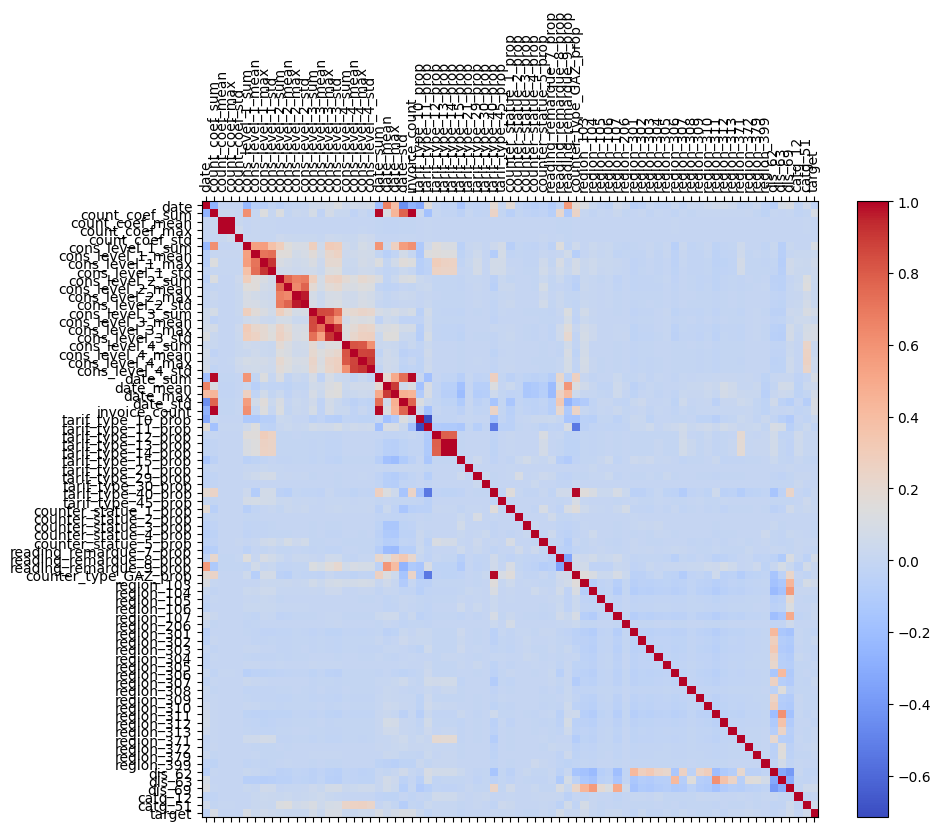

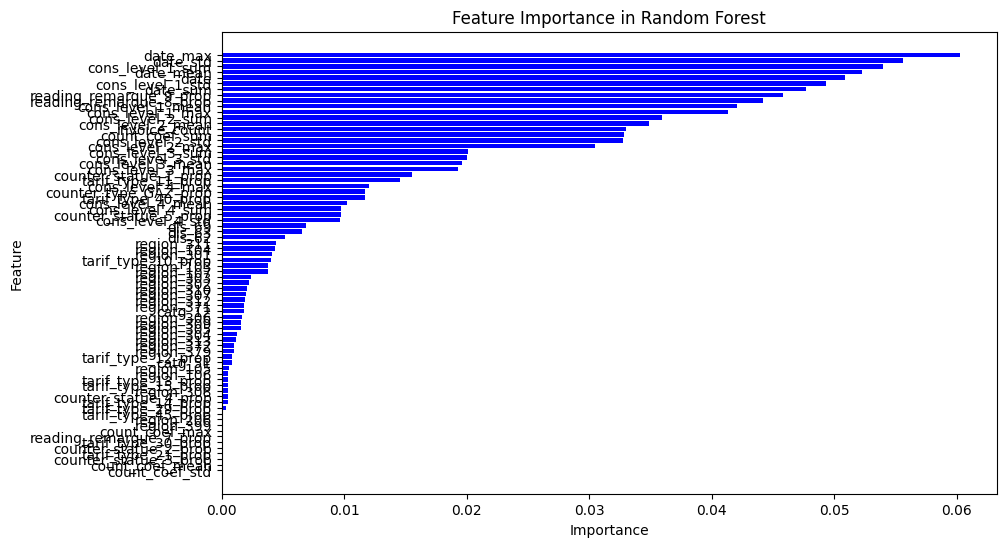

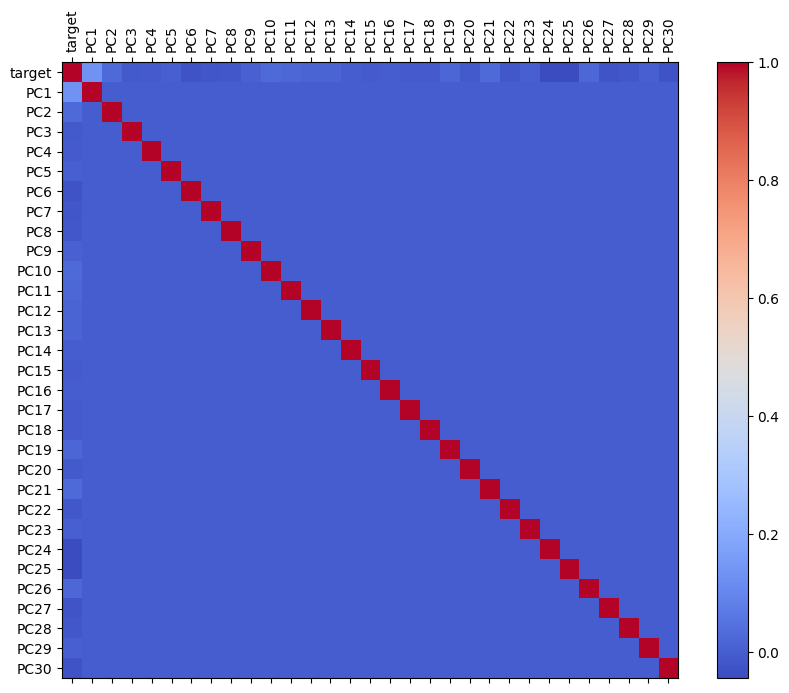

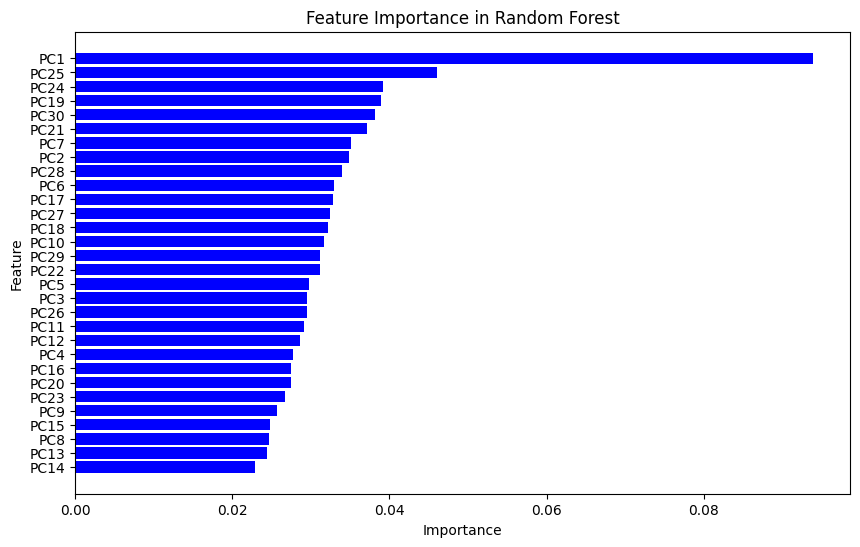

target
0    20576
1     1076
Name: count, dtype: int64
target
0    5380
1    5380
Name: count, dtype: int64
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.687917  2.238876 -0.037945  1.401438  0.929980 -1.402848  1.081001   
1 -0.365705 -1.880599 -0.389247 -1.180866 -1.412071 -0.634523  0.845822   
2 -1.621469 -0.668619 -0.859840 -0.221082 -0.384637 -0.266601  1.216537   
3  0.597655  1.384595 -0.027888  0.873606  0.427986 -1.217860  0.925283   
4 -2.102182 -1.577431 -1.178701 -0.927617 -0.927692  0.036127  1.420901   

        PC8       PC9      PC10  ...      PC22      PC23      PC24      PC25  \
0 -0.436427  0.367593 -0.720656  ... -0.045867  0.137321  0.566610 -0.282687   
1  0.135615 -0.130120  0.562239  ...  0.109630 -0.267659 -0.106975 -0.291504   
2 -0.350357  0.337642 -0.104710  ...  0.038862 -0.213106  0.488952  0.121296   
3 -0.207967  0.165417 -0.554820  ...  0.026219  0.092722  0.243456 -0.331325   
4 -0.261178  0.252020  0.365938  ... -0.1

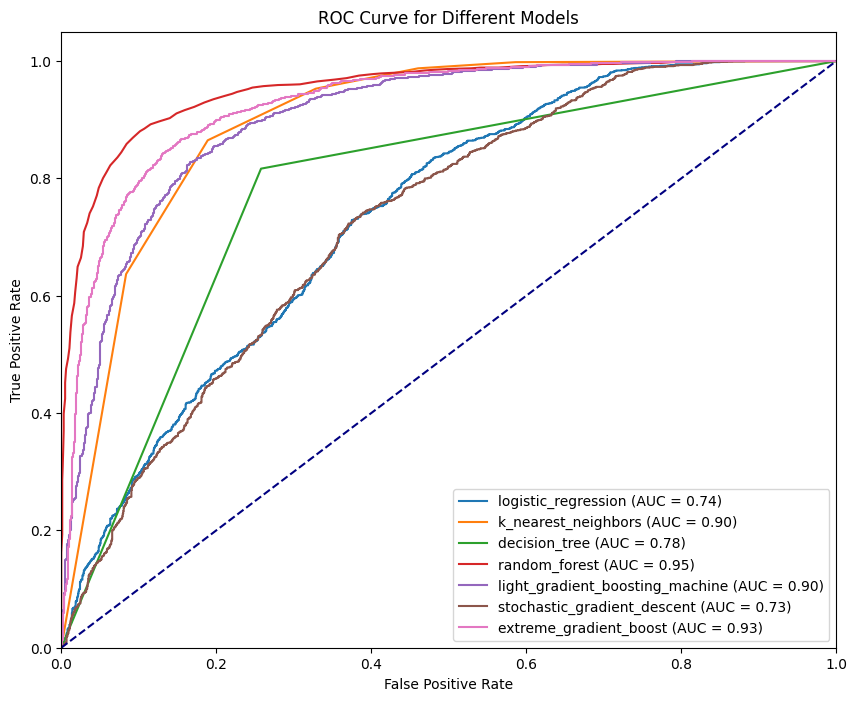

[I 2024-10-31 22:14:44,787] A new study created in memory with name: no-name-9090f133-a7d5-4f0d-8beb-48f3db46d85e
[I 2024-10-31 22:14:44,902] Trial 0 finished with value: 0.7319750970826826 and parameters: {}. Best is trial 0 with value: 0.7319750970826826.
[I 2024-10-31 22:14:44,903] A new study created in memory with name: no-name-352c5899-36fe-4f74-a32e-fe31e202ac24
[I 2024-10-31 22:14:50,460] Trial 0 finished with value: 0.9255741179640967 and parameters: {'k': 6, 'power_parameter': 3, 'weights': 'distance'}. Best is trial 0 with value: 0.9255741179640967.
[I 2024-10-31 22:14:56,219] Trial 1 finished with value: 0.8080912888157986 and parameters: {'k': 30, 'power_parameter': 3, 'weights': 'uniform'}. Best is trial 0 with value: 0.9255741179640967.
[I 2024-10-31 22:14:56,647] Trial 2 finished with value: 0.9098126926106603 and parameters: {'k': 18, 'power_parameter': 1, 'weights': 'distance'}. Best is trial 0 with value: 0.9255741179640967.
[I 2024-10-31 22:14:57,583] Trial 3 finish

Model: logistic_regression, Recall: 0.7174721189591078
Model: k_nearest_neighbors, Recall: 0.9684014869888475
Model: decision_tree, Recall: 0.718091697645601
Model: random_forest, Recall: 0.7757125154894672
Model: light_gradient_boosting_machine, Recall: 0.9058240396530359
Model: stochastic_gradient_descent, Recall: 0.6871127633209417
Model: extreme_gradient_boost, Recall: 0.9169764560099133


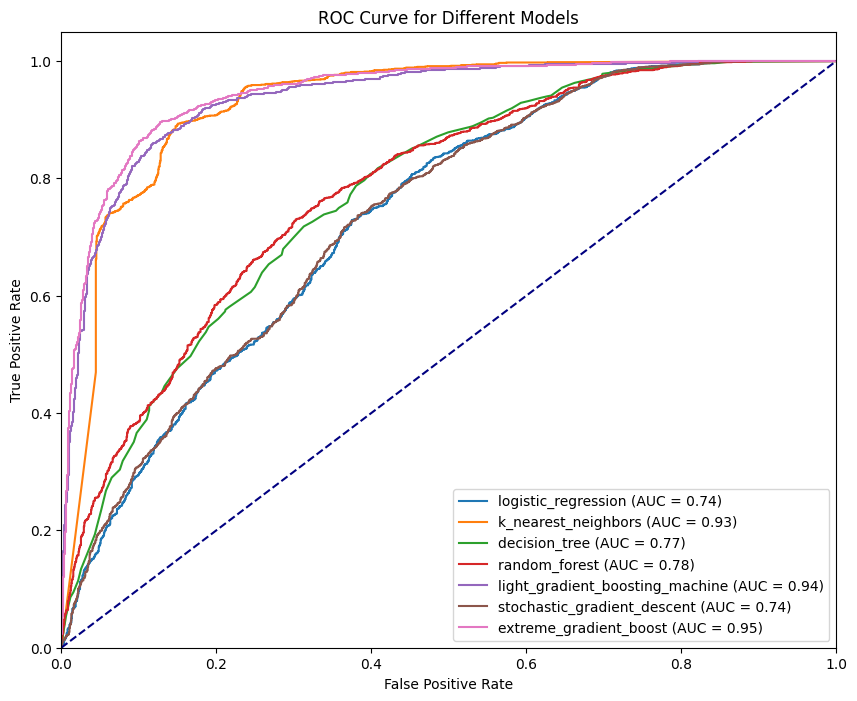

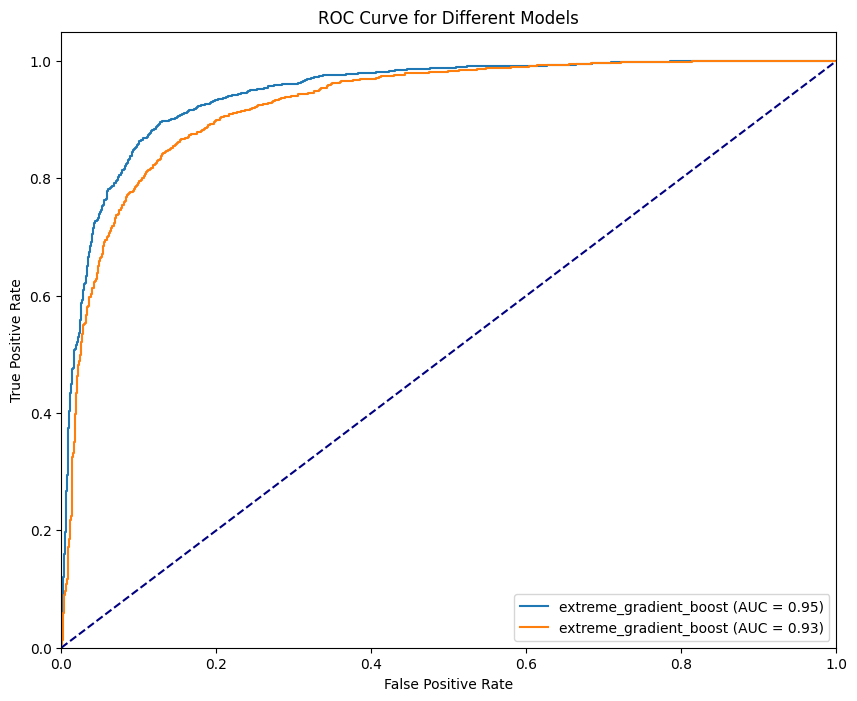

[('extreme_gradient_boost', np.float64(0.9459193027551673)), ('extreme_gradient_boost', np.float64(0.9269841489199983))]


[('extreme_gradient_boost', np.float64(0.9459193027551673)),
 ('light_gradient_boosting_machine', np.float64(0.9376448178807184)),
 ('k_nearest_neighbors', np.float64(0.9279367415535379)),
 ('random_forest', np.float64(0.7826411249767754)),
 ('decision_tree', np.float64(0.774835162894684)),
 ('stochastic_gradient_descent', np.float64(0.7371224370402104)),
 ('logistic_regression', np.float64(0.7357324157119628))]

In [42]:
## Run to execute main workflow

main()
